In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
from random import uniform, seed
from math import sqrt
import numpy as np
from Cell2D import Cell2D, draw_array
from matplotlib.colors import LinearSegmentedColormap
from scipy import signal
import seaborn as sns
from matplotlib import cm
from numpy import random
palette = sns.color_palette()
colors = 'white', 'red', 'blue', 'orange'
cmap = LinearSegmentedColormap.from_list('cmap', colors)

In [24]:
# Defining a cmap that we can use where zeros (empty houses) will stand out - setting them to black
cmap_show_empty = cm.YlOrRd.copy()
cmap_show_empty.set_bad(color='black')

In [25]:
seed(10)

In [26]:
# Defining a class for the houses
class grid_houses(Cell2D):
    """Represents a grid of Schelling agents."""
    
    def __init__(self, n, prob_empty,kernel):
        """Initializes the attributes.
        
        n: is the dimension of our square numpy array (n x n)

        """
        super().__init__(n)
        self.prob_empty = prob_empty    # probability of empty cells occurring
        self.kernel = kernel

        self.values = np.random.rand(n, n) # uniformly distribute the house values between 0 and 1
        choices = np.array([0, 1], dtype = np.int8)
        self.array = np.random.choice(2, (n, n), p = [self.prob_empty, 1 - self.prob_empty]) # randomly choosing which houses are empty, with probability prob_empty

        self.padding = np.ones_like(self.array)
        self.padding[0,:] = np.zeros_like(self.padding[0,:])
        self.padding[1,:] = np.zeros_like(self.padding[1,:])
        self.padding[-1,:] = np.zeros_like(self.padding[-1,:])
        self.padding[-2,:] = np.zeros_like(self.padding[-2,:])
        self.padding[:,0] = np.zeros_like(self.padding[:,0])
        self.padding[:,1] = np.zeros_like(self.padding[:,1])
        self.padding[:,-1] = np.zeros_like(self.padding[:,-1])
        self.padding[:,-2] = np.zeros_like(self.padding[:,-2])

        self.array = np.multiply(self.padding, self.array) # setting the house indicator to zero for the padding
        self.values= np.multiply(self.values, self.array) # sets the house values to zero if there is no house at that spot

    def average_neighbors(self):
        '''
        calculates the of the values of neighbors' house values, where the radius is defined by the kernel matrix. Note - boundary = fill automatically 'pads' the matrix with zeros on the boundary, which leads to lower averages there, so lower house prices near the boundary. We should look into a wrap boundary or possibly filling with a different value, eg average house price.
        :return: array of the averages
        '''
        total = signal.convolve2d(self.values, self.kernel, boundary='wrap', mode='same')
        # adding the number of total grid points
        number = signal.convolve2d(self.array, self.kernel, boundary='wrap', mode='same')
        print("No of neighbours: ", number)
        print("Total: ", total)

        # finding the average
        average = np.zeros_like(self.array, dtype = float)
        average[2:-2,2:-2] += np.divide(total,number)[2:-2,2:-2]


        # resetting the values to zero for squares that don't have a house
        output = np.multiply(self.array,average)
        output = np.multiply(output, self.array) # setting the house indicator to zero for the padding
        return(output)

    def draw_values(self):
        '''
        Just defined a function to draw the house values so we can draw both a map of houses and a map of house values
        '''
        # mask some 'bad' data, in your case you would have: data == 0
        values = np.ma.masked_where(self.values == 0, self.values)
        return draw_array(values, cmap = cmap_show_empty)

    def update_values(self, grid_agents, lam1, lam2):
        '''
        Coding for the function we use to update house prices, at a matrix level. We can use
        :param grid_agents:
        :param lam:
        :return:
        '''
        self.values = lam1*self.average_neighbors() + lam2*grid_agents.affluences

    def draw_neighbors(self):
        return draw_array(self.average_neighbors())


In [27]:
# Defining a class for the agents
class grid_agents(Cell2D):
    """Represents a grid of Schelling agents."""

    def __init__(self, n, prob_empty,grid_houses):
        """Initializes the attributes.
        """
        super().__init__(n)
        #self.affluences = np.random.rand(n,n)
        self.prob_emp = prob_empty    # probability of empty cells occurring
        # self.prob_rich = (1 - self.prob_emp)/3
        # self.prob_middle= (1 - self.prob_emp)/3
        # self.prob_poor = (1 - self.prob_emp)/3
        self.size = n
        # limiting this to just two, the zeros here give us empty houses, but I'm not sure this is really necessary since we just swap people's houses anyway.
        # use the numpy routine choice to select the different cells with probability
        #self.array = np.random.choice(choices, (n, n), p = probs)
        # self.array = np.multiply(self.array,grid_houses.array)
        choices = np.array([0.1,.5,1])
        probs = [1/3, 1/3, 1/3]
        self.affluences = np.random.choice(choices, (n, n), p = probs)
        self.affluences = np.multiply(self.affluences,grid_houses.array)

    def draw(self):
        """Draws the cells."""
        return draw_array(self.array, cmap=cmap, vmax=3)

    def draw_affluences(self):
        '''
        Draws the grid of affluences.
        '''
        # mask some 'bad' data, in your case you would have: data == 0
        affluences = np.ma.masked_where(self.affluences == 0, self.affluences)
        return draw_array(affluences, cmap = cmap_show_empty)

    def swap_people(self, grid_houses):
        '''
        Picks two random grid elements, if they aren't zero and the delta function is greater than 0, swaps them
        :param grid_houses: we need this as an input, since we need to get house values for the two agents, for the delta function.
        :return:
        '''
        i1 = random.randint(2,self.size-2)
        j1 = random.randint(2,self.size-2)
        i2 = random.randint(2,self.size -2)
        j2 = random.randint(2,self.size-2)
        #print(i1,j1,i2,j2)
        if j1 != j2 or i1 != i2:
            if grid_houses.array[i1][j1] != 0 and grid_houses.array[i2][j2] != 0:
                t1 = (grid_houses.values[i1][j1]- self.affluences[i1][j1])**2 + (grid_houses.values[i2][j2]- self.affluences[i2][j2])**2
                t2 = (grid_houses.values[i1][j1]- self.affluences[i2][j2])**2 + (grid_houses.values[i2][j2]- self.affluences[i1][j1])**2
                if t1 > t2:
                    # print("t1 = ",t1)
                    # print("t2 = ",t2)
                    # print("swapped agents")
                    # print(f"i1: {i1}, j1: {j1} \n i2: {i2}, j2: {j2}")
                    # print("First ",self.affluences[i1][j1])
                    # print("Second ",self.affluences[i2][j2])
                    self.affluences[i2,j2], self.affluences[i1,j1] = self.affluences[i1,j1],self.affluences[i2,j2]

    # def swap_people(self, grid_houses):
    #     '''
    #     Picks two random grid elements, if they aren't zero and the delta function is greater than 0, swaps them
    #     :param grid_houses: we need this as an input, since we need to get house values for the two agents, for the delta function.
    #     :return:
    #     '''
    #     print(self.affluences)
    #     print(grid_houses.values)
    #     x1 = range(self.array.shape[1])
    #     x2 = range(self.array.shape[0])
    #     y1 =range(self.array.shape[1])
    #     y2 =range(self.array.shape[0])
    #     x1 = list(x1)
    #     x2 = list(x2)
    #     y1 = list(y1)
    #     y2 = list(y2)
    #     random.shuffle(x1)
    #     random.shuffle(x2)
    #     random.shuffle(y1)
    #     random.shuffle(y2)
    #
    #     for i1 in x1:
    #         for j1 in x2:
    #             for i2 in y1:
    #                 for j2 in y2:
    #                     if j1 != j2 or i1 != i2:
    #                         if grid_houses.array[i1][j1] != 0 and grid_houses.array[i2][j2] != 0:
    #                             # print("House 1: ",grid_houses.values[i1][j1])
    #                             # print("House 2: ",grid_houses.values[i2][j2])
    #                             t1 = (grid_houses.values[i1][j1]- self.affluences[i1][j1])**2 + (grid_houses.values[i2][j2]- self.affluences[i2][j2])**2
    #                             t2 = (grid_houses.values[i1][j1]- self.affluences[i2][j2])**2 + (grid_houses.values[i2][j2]- self.affluences[i1][j1])**2
    #                             # print("t1 =",t1)
    #                             # print("t2 =",t2)
    #                             if t1 > t2:
    #                                 self.affluences[i2,j2], self.affluences[i1,j1] = self.affluences[i1,j1],self.affluences[i2,j2]
    #                                 return True
    #     return False

In [28]:
# kernel used for counting a cell's neighbours
kernel = np.array([[1,1,1, 1, 1],
                   [1,1,1, 1, 1],
                   [1,1, 1, 1,1],
                   [1,1,1, 1, 1],
                   [1,1,1, 1, 1]], dtype=np.int8)

In [8]:
grid_agents1.draw_affluences()

NameError: name 'grid_agents1' is not defined

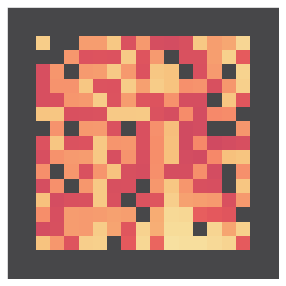

In [308]:
grid_houses1.draw_values()

## Running the code (100,000 times)

In [36]:
grid_houses1 = grid_houses(19,.1, kernel)
grid_agents1 = grid_agents(19, 0.1, grid_houses1)

In [30]:
print(grid_houses1.values)
print(grid_houses1.average_neighbors())

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.07322972 0.         0.         0.49595304
  0.67301244 0.95826069 0.56938105 0.96550353 0.8151944  0.49255375
  0.45819688 0.05508958 0.12167874 0.91872879 0.50224469 0.
  0.        ]
 [0.         0.         0.50462029 0.         0.49247776 0.78475192
  0.         0.55736799 0.17966477 0.58279963 0.24954934 0.2862355
  0.02770076 0.72013751 0.45953169 0.64556248 0.04897695 0.
  0.        ]
 [0.         0.         0.18234461 0.         0.70823578 0.53937491
  0.77252272 0.         0.99580606 0.21328232 0.91791707 0.
  0.54885835 0.26949488 0.         0.74888618 0.45933882 0.
  0. 

### This is where the code isn't working. swap_people returns true if there's a swap and false if there isn't. It iterates through the array in a random order to find a swap. Even with lambda = 0.6, the updated house values are too close to the inhabitants' affluences, so that nobody will benefit from a swap so it returns false after just one update.

In [37]:
print(grid_agents1.swap_people(grid_houses1))
grid_houses1.update_values(grid_agents1,0.8, 0.15)
print(grid_agents1.swap_people(grid_houses1))

None
No of neighbours:  [[ 1  2  3  4  5  5  5  5  5  5  5  5  5  5  5  4  3  2  1]
 [ 2  3  4  6  8  7  8  9  8  8  9  9  9 10 10  8  6  4  2]
 [ 3  5  6  9 12 11 11 13 11 11 11 11 10 12 11  9  7  5  2]
 [ 4  7  8 12 15 14 14 17 15 16 16 16 15 17 16 13 10  7  3]
 [ 5  9 11 16 20 18 18 21 19 20 21 21 19 21 20 16 12  9  4]
 [ 5  9 11 16 20 17 17 20 18 19 21 21 18 20 19 15 11  9  4]
 [ 4  9 12 17 20 19 18 20 19 21 22 22 19 20 19 15 11  9  4]
 [ 4  9 13 18 21 20 20 21 21 23 25 25 23 23 23 18 13 10  5]
 [ 4  8 13 18 22 21 22 22 21 22 24 24 21 22 22 17 12 10  5]
 [ 4  8 13 18 22 22 23 23 22 23 24 23 21 22 22 17 13 10  5]
 [ 4  7 12 17 20 21 23 23 22 24 24 22 21 22 22 17 14 10  5]
 [ 5  8 13 18 22 22 24 24 23 24 24 21 20 21 21 16 14 10  5]
 [ 5  8 13 18 21 21 23 23 22 24 24 20 19 20 20 15 14 10  5]
 [ 5  9 14 19 22 22 23 23 23 25 25 21 21 21 20 15 14  9  4]
 [ 5  9 14 19 22 22 23 23 23 25 25 22 22 22 21 16 14  9  4]
 [ 4  8 12 16 19 19 19 19 19 20 20 18 18 18 17 13 11  7  3]
 [ 3  6  9 12 14

### Running it for a 9x9 grid it's easy to see what's happening, after one update the house values are set so close to the agent affluences that there are no more swaps that will improve things. It seems like maybe it works better if affluences are uniformly distributed. As it stands, a person will never swap with one outside their affluence class, and for two people in the same affluence class the delta function will always be zero, so they don't swap either.

### Important: There's an issue here - we should maybe look at changing this so update_values returns the true or false value

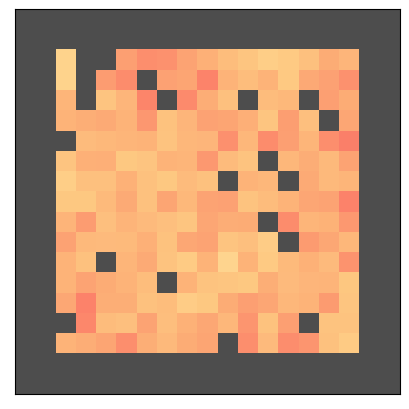

In [32]:
grid_houses1.draw_values()

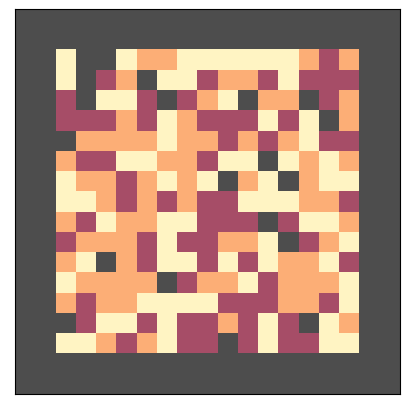

In [33]:
grid_agents1.draw_affluences()

In [35]:
i=0
swap_exists = True
while swap_exists:
    grid_houses1.update_values(grid_agents1,lam1=.4,lam2=.6)
    swap_exists = grid_agents1.swap_people(grid_houses1)
    print(swap_exists)
    i += 1
    print(i)

No of neighbours:  [[ 1  1  1  2  3  3  4  5  5  5  5  5  5  5  5  4  3  2  1]
 [ 2  2  3  5  6  6  8  9  9 10 10 10 10 10 10  8  6  4  2]
 [ 3  3  5  8 10  9 12 13 13 13 14 14 13 13 14 11  8  6  3]
 [ 4  5  8 12 15 14 17 18 18 18 19 19 18 17 18 14 10  7  4]
 [ 4  6 10 15 19 19 22 23 23 23 24 24 23 22 23 18 13  9  5]
 [ 4  7 12 17 21 21 23 23 23 23 23 23 22 21 22 18 13  9  5]
 [ 4  8 13 18 23 23 24 24 23 22 22 21 20 20 21 17 13  9  5]
 [ 4  9 14 19 24 25 25 25 24 24 23 22 22 22 22 18 14  9  5]
 [ 4  9 14 19 24 25 25 25 24 24 22 21 21 22 22 19 15 10  5]
 [ 5 10 15 20 25 25 25 25 24 24 22 20 20 21 21 18 15 10  5]
 [ 5 10 14 19 24 24 24 25 24 24 23 21 21 22 22 18 15 10  5]
 [ 5 10 14 19 24 23 23 24 24 24 24 23 23 23 23 19 15 10  5]
 [ 5 10 14 19 24 23 23 24 24 24 24 23 23 23 23 19 15 10  5]
 [ 4  9 13 18 23 23 23 24 24 24 25 24 23 23 23 18 14 10  5]
 [ 4  9 13 18 23 23 23 24 23 23 24 24 23 24 24 19 14 10  5]
 [ 3  7 11 15 19 19 19 19 18 18 19 19 18 19 19 15 11  8  4]
 [ 2  5  8 11 14 15 1

In [54]:
def inequality(A):
    """
    Function to find inequality given the aflluence matrix A
    """
    poor = 0
    middle = 0  
    rich = 0
    
    for x in range(np.shape(A)[0]):
        for y in range(np.shape(A)[1]):
            if float(A[x,y]) == 0.1:
                poor += 1
            elif float(A[x,y]) == 0.5:
                middle += 1
            if float(A[x,y]) == 1.0:
                rich += 1
    sum = poor+middle+rich
    I = np.log(3) + poor/sum * np.log(poor/sum) + middle/sum * np.log(middle/sum) + rich/sum * np.log(rich/sum)
    return(I)

In [87]:
inequality_values = []

for x in range(0,10000):
    grid_houses1 = grid_houses(19,.1, kernel)
    grid_agents1 = grid_agents(19, 0.1, grid_houses1)
    inequality_values.append(inequality(grid_agents1.affluences))
print(np.max(inequality_values))

0.050480942495016945
